# Описание проекта

Металлургический комбинат «Стальная птица» стремится снизить производственные расходы за счёт оптимизации энергопотребления на этапе обработки стали.
Для этого предприятию необходимо контролировать и прогнозировать температуру сплава во время технологического процесса.

**Цель проекта** - построить модель машинного обучения для предсказания температуры стали на различных этапах обработки.
Полученная модель будет использоваться для имитации технологического процесса и оптимизации расхода электроэнергии.

**Задачи проекта:**

* Загрузить и объединить данные из различных источников.

* Провести первичный анализ данных и очистку от выбросов и пропусков.

* Выполнить исследовательский анализ данных.

* Построить и обучить модель машинного обучения для прогнозирования температуры сплава.

* Настроить гиперпараметры модели и оценить её качество по метрике MAE.

* Сделать выводы

In [1]:
!pip install numpy==1.26.4
!pip install scikit-learn==1.6.1
!pip install matplotlib==3.9.2
!pip install seaborn==0.13.2
!pip install phik==0.12.5
!pip install eli5==0.16.0

  Using cached numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.
  Using cached numpy-1.24.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followi

Устанавливаю удобные для работы версии библиотек

In [2]:
#EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
#preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
#Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
#Метрики
from sklearn.metrics import mean_absolute_error
#else
import warnings
import sklearn
import matplotlib
import eli5
from eli5.sklearn import PermutationImportance

In [3]:
print("Версия seaborn:", sns.__version__)
print("Версия scikit-learn:", sklearn.__version__)
print("Версия numpy:", np.__version__)
print("Версия pandas:", matplotlib.__version__)
print("Версия eli5:", eli5.__version__)
print("Версия phik:", phik.__version__)

Версия seaborn: 0.13.2
Версия scikit-learn: 1.6.1
Версия numpy: 1.24.4
Версия pandas: 3.9.2
Версия eli5: 0.16.0
Версия phik: 0.12.5


Импортирую нужные библиотеки

In [4]:
warnings.filterwarnings('ignore') #Убираю warning-и, чтобы не мешали выводу

#Гипперпараметры
RANDOM_STATE = 61025
TEST_SIZE = 0.25

#Инициализация модели
cat_model = CatBoostRegressor(
    loss_function='MAE',
    eval_metric='MAE',
    verbose=False,
    random_seed=RANDOM_STATE,
    grow_policy = 'SymmetricTree'
)

Константы

In [5]:
#Функция для визуализации EDA графиков: гистограмма, boxplot
def num_plot(data,column_list,bins=50,figsize=(12,4)):
    for column in column_list:
        plt.figure(figsize=(figsize))
        # Первый subplot - ГИСТОГРАММА
        plt.subplot(1,2,1)
        sns.histplot(data=data,x=column,kde=True,bins=bins)
        plt.title(f'Гистограмма {column}')
        plt.xlabel(f'Значения {column}')
        plt.ylabel('Частота')
        plt.grid()
        # Второй subplot - BOXPLOT
        plt.subplot(1,2,2)
        sns.boxplot(data=data,y=column)
        plt.title(f'Boxplot {column}')
        plt.xlabel('Boxplot')
        plt.ylabel('Значения')
        plt.grid()
        plt.show()

#Функция для визуализации EDA графиков: countplot
def count_plot(data,column_list):
    for column in column_list:
        plt.figure(figsize=(10,4))
        sns.countplot(data=data,x=column,palette='deep')
        plt.title(f'Количество {column}')
        plt.xlabel('Значения')
        plt.ylabel('Количество значений')
        plt.show()

Функции

# Загрузка данных и первичный осмотр

In [6]:
data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [7]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [8]:
data_arc_new.duplicated().sum()

0

Данные об электродах успешно загружены. Дубликаты и пропущенные значения в датасете отсутствуют. Содержание датасета соответствует описанию. Столбцы, содержащие информацию о времени начала и окончания нагрева дугой, имеют неверный тип данных. Необходимо преобразовать их в datetime для корректной работы с датой и временем. С точки зрения стилистических норм языка python, необходимо переименовать названия столбцов на латиницу (в соответствии с общим стилем) и заменить пробелы нижним подчёркиванием по правилам змеиного регистра.

In [9]:
data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [10]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [11]:
data_bulk_new.duplicated().sum()

0

В загруженной таблице столбцы содержат информацию о объеме материалов для каждой партии key. Наличие пропусков свидетельствует о том, что тот или иной материал не был использован для данной партии сплава. Такие пропуски являются абсолютно нормальным явлением, и должны заполняться логичным константным значением - 0. Явные дубликаты в данных не обнаружены. Названия столбцов содержат стилистическую ошибку.

In [12]:
data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [13]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [14]:
data_bulk_time_new.duplicated().sum()

0

К таблице с объемом подачи сыпучих материалов также прилагается таблица со временем подачи. Поведение данных полностью идентичное. 

In [15]:
data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [16]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [17]:
data_gas_new.duplicated().sum()

0

Информация о продувке сплава газом является полной: пропуски и дубликаты не найдены. 

In [18]:
data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [19]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [20]:
data_temp_new.duplicated().sum()

0

Датафрейм содержит информацию об измерении температуры - это наш целевой признак. В столбце со значениями температуры содержится примерно 19% пропущенных значений от общего числа записей по номеру партии. Заполнение такого количества NaN-значений искусственными наблюдениями(медианой, средним или модой) может сильно исказить распределение и логику для модели. Поэтому наилучшим вариантом будет удалить пропуски. Названия столбцов необходимо привести к единому стилю.

In [21]:
data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [23]:
data_wire_new.duplicated().sum()

0

Аналогично датасету сыпучих материлов, таблица содержит информацию о объемах подаваемых проволочных материалов. Наличие пропусков обусловлено тем, что в разных партиях использовались разные проволочные материалы в разном количестве. Пропуски можно смело заполнить нулями. Названия столбцов не соответствуют стилистическим нормам записи.

In [24]:
data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [26]:
data_wire_time_new.duplicated().sum()

0

Таблица содержит информацию о времени подачи проволочных материалов.

# Предобработка данных

In [27]:
df_arc = data_arc_new.copy()
df_bulk = data_bulk_new.copy()
df_wire = data_wire_new.copy()
df_temp = data_temp_new.copy()
df_gas = data_gas_new.copy()

Cоздаю копии датафреймов

**Переименование столбцов**

In [28]:
df_arc = df_arc.rename(columns={
    'Начало нагрева дугой': 'arc_start',
    'Конец нагрева дугой': 'arc_end',
    'Активная мощность': 'active_power_raw',
    'Реактивная мощность': 'reactive_power_raw'
})
df_arc.columns

Index(['key', 'arc_start', 'arc_end', 'active_power_raw',
       'reactive_power_raw'],
      dtype='object')

In [29]:
df_bulk.columns = ['key',
    'bulk_1','bulk_2','bulk_3','bulk_4','bulk_5',
    'bulk_6','bulk_7','bulk_8','bulk_9','bulk_10',
    'bulk_11','bulk_12','bulk_13','bulk_14','bulk_15'
]
df_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [30]:
df_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6','wire_7', 'wire_8', 'wire_9']
df_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [31]:
df_temp = df_temp.rename(columns={
    'Время замера':'measurement_time',
    'Температура':'temp'
})
df_temp.columns

Index(['key', 'measurement_time', 'temp'], dtype='object')

In [32]:
df_gas = df_gas.rename(columns={
    'Газ 1':'gas_1'
})
df_gas.columns

Index(['key', 'gas_1'], dtype='object')

Столбцы были приведены к единому стилю. Все стилистические нормы Python учтены

**Изменение типов данных**

In [33]:
df_arc['arc_start'] = pd.to_datetime(df_arc['arc_start'],format='%Y-%m-%d %H:%M:%S')
df_arc['arc_end'] = pd.to_datetime(df_arc['arc_end'],format='%Y-%m-%d %H:%M:%S')

Тип данных был успешно преобразован в datetime

**Обработка пропусков**

In [34]:
df_bulk = df_bulk.fillna(0)
df_bulk.isna().sum()

key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

In [35]:
df_wire = df_wire.fillna(0)
df_wire.isna().sum()

key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

Пропуски с отсутствующими материалами были заполнены нулями

In [36]:
bad_key = df_temp.loc[df_temp['temp'].isna(),'key'].unique()
df_temp = df_temp.loc[~df_temp['key'].isin(bad_key)]
df_temp.isna().sum()

key                 0
measurement_time    0
temp                0
dtype: int64

Все партии, с пропущенными значениями температуры, были удалены

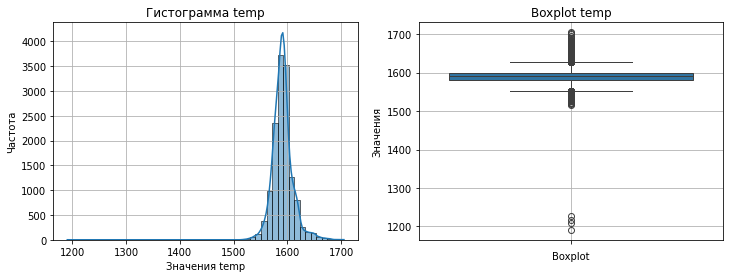

In [37]:
num_plot(df_temp,['temp'])

In [38]:
df_temp['temp'].describe()

count    13926.000000
mean      1590.802671
std         19.845377
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temp, dtype: float64

Столбец с температурой является ключевым. Его конечные значения нам и придется предсказывать. По результатам визуализации признака можно сделать следующие выводы:

Распределение данных визуально ассиметрично с выраженным левым хвостом, однако численные метрики mean=median (1590=1590.8) свидетельствуют о статистической компенсации хвостов. График boxplot идеально показывает реальное поведение данных: не только наличие редких и экстремально низких выбросов (Минимальное значение = 1192,Q1 - 1.5IQR = 1515), но и наличие выбросов выше верхней границы boxplot (Максимальное значение = 1705, Q3 + 1.5IQR = 1627.5), которые встречаются чаще и приближены к основной массе. Левосторонние выбросы отражают некорректно зафиксированные низкие температуры, которые смещают распределение и могут искажать корреляции между температурой и характеристиками плавки, поэтому необходимо отфильтровать данные.

In [39]:
df_temp_key = df_temp.loc[df_temp['temp'] < 1400, 'key'].unique()
df_temp = df_temp.loc[~df_temp['key'].isin(df_temp_key)]

Так как ключ ковша не уникален, каждая запись отражает отдельный этап плавки, а итоговый датасет предполагает дальнейшую агрегацию по ковшам.

При удалении отдельных строк с экстремально низкими температурами значения остальных признаков ковша станут неполными, что приведёт к некорректным агрегатам и искажению статистики.

Поэтому, если хотя бы на одном этапе ковша зафиксировано экстремально низкое значение температуры, такой ковш следует исключить целиком, чтобы сохранить целостность данных.

**Создание признаков для модели**

In [40]:
df_arc['duration'] = (df_arc['arc_end'] - df_arc['arc_start']).dt.total_seconds().clip(lower=0)
df_arc['reactive_power'] = df_arc['reactive_power_raw'] * df_arc['duration']
df_arc['active_power'] = df_arc['active_power_raw'] * df_arc['duration']

В рамках feature engineering из исходных данных сформированы новые признаки, отражающие временную и энергетическую составляющие процесса нагрева:

* duration - длительность цикла нагрева дугой

* reactive_power - реактивная мощность за период нагрева

* active_power - активная мощность за период нагрева

In [41]:
df_arc = df_arc.groupby('key').agg(
    arc_count = ('arc_start','count'),
    arc_duration_mean = ('duration','mean'),
    arc_duration_sum = ('duration','sum'),
    arc_duration_std = ('duration','std'),
    active_power_sum = ('active_power','sum'),
    active_power_mean = ('active_power','mean'),
    reactive_power_sum = ('reactive_power','sum'),
    max_active_power = ('active_power_raw','max'),
    min_active_power = ('active_power_raw','min')
).reset_index()
df_arc.head()

,key,arc_count,arc_duration_mean,arc_duration_sum,arc_duration_std,active_power_sum,active_power_mean,reactive_power_sum,max_active_power,min_active_power
0,1,5,219.60,1098.0,86.315120,628.616930,125.723386,444.489437,0.867133,0.305130
1,2,4,202.75,811.0,97.568352,395.281800,98.820450,274.689995,0.786322,0.261665
2,3,5,131.00,655.0,86.611200,581.774624,116.354925,428.038924,1.222963,0.421693
3,4,4,185.25,741.0,75.966550,543.710274,135.927569,413.941977,0.887855,0.310693
4,5,4,217.25,869.0,151.548397,412.180480,103.045120,303.070918,0.892957,0.324563


Так как одной партии (key) соответствует несколько записей, данные о каждой плавке распределены по множеству строк.
Чтобы модель не запуталась из-за множественных наблюдений одной партии и могла воспринимать каждую плавку как единичный объект, необходимо агрегировать данные по ключу.

In [42]:
df_bulk_sum = df_bulk.groupby('key').sum().reset_index()
df_bulk_sum.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Суммируем объемы всех сыпучих материалов партии

In [43]:
df_wire_sum = df_wire.groupby('key').sum().reset_index()
df_wire_sum.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Суммируем объемы всех проволочных материалов партии

In [44]:
df_gas_sum = df_gas.groupby('key').agg(
    gas_sum = ('gas_1','sum')
).reset_index()
df_gas_sum.head()

,key,gas_sum
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Суммируем объем подаваемого газа каждой партии

In [45]:
df_first_temp = df_temp.sort_values(['key','measurement_time'],ascending=True).groupby('key').head(1)
df_first_temp = df_first_temp[['key','temp']].rename(columns={'temp':'first_temp'})

Добавляем фактор со значением первой температуры 

In [46]:
df_target_temp = df_temp.sort_values(['key','measurement_time'],ascending=True).groupby('key').tail(1)
df_target_temp = df_target_temp[['key','temp']].rename(columns={'temp':'target_temp'})

Берем конечную температуру, как нашу целевую переменную

**Слияние таблиц**

In [47]:
df = df_arc.merge(
    df_gas_sum,on='key',how='left'
).merge(
    df_target_temp,on='key',how='left'
).merge(
    df_first_temp,on='key',how='left'
).merge(
    df_bulk_sum,on='key',how='left'
).merge(
    df_wire_sum,on='key',how='left'
)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 3214 non-null   int64  
 1   arc_count           3214 non-null   int64  
 2   arc_duration_mean   3214 non-null   float64
 3   arc_duration_sum    3214 non-null   float64
 4   arc_duration_std    3175 non-null   float64
 5   active_power_sum    3214 non-null   float64
 6   active_power_mean   3214 non-null   float64
 7   reactive_power_sum  3214 non-null   float64
 8   max_active_power    3214 non-null   float64
 9   min_active_power    3214 non-null   float64
 10  gas_sum             3212 non-null   float64
 11  target_temp         2471 non-null   float64
 12  first_temp          2471 non-null   float64
 13  bulk_1              3128 non-null   float64
 14  bulk_2              3128 non-null   float64
 15  bulk_3              3128 non-null   float64
 16  bulk_4

In [49]:
df.duplicated().sum()

0

В результате слияния таблиц по ключу, в данных образовались новые пропуски. Необходимо их обработать

In [50]:
df = df.dropna()
print('Количество пропусков в объединённом датасете:',df.isna().sum().sum())
print('Количество строк в таблице:',df.shape[0])

Количество пропусков в объединённом датасете: 0
Количество строк в таблице: 2300


Строки с пустыми значениями были удалены

# Исследовательский анализ данных

**Повторный первичный анализ**

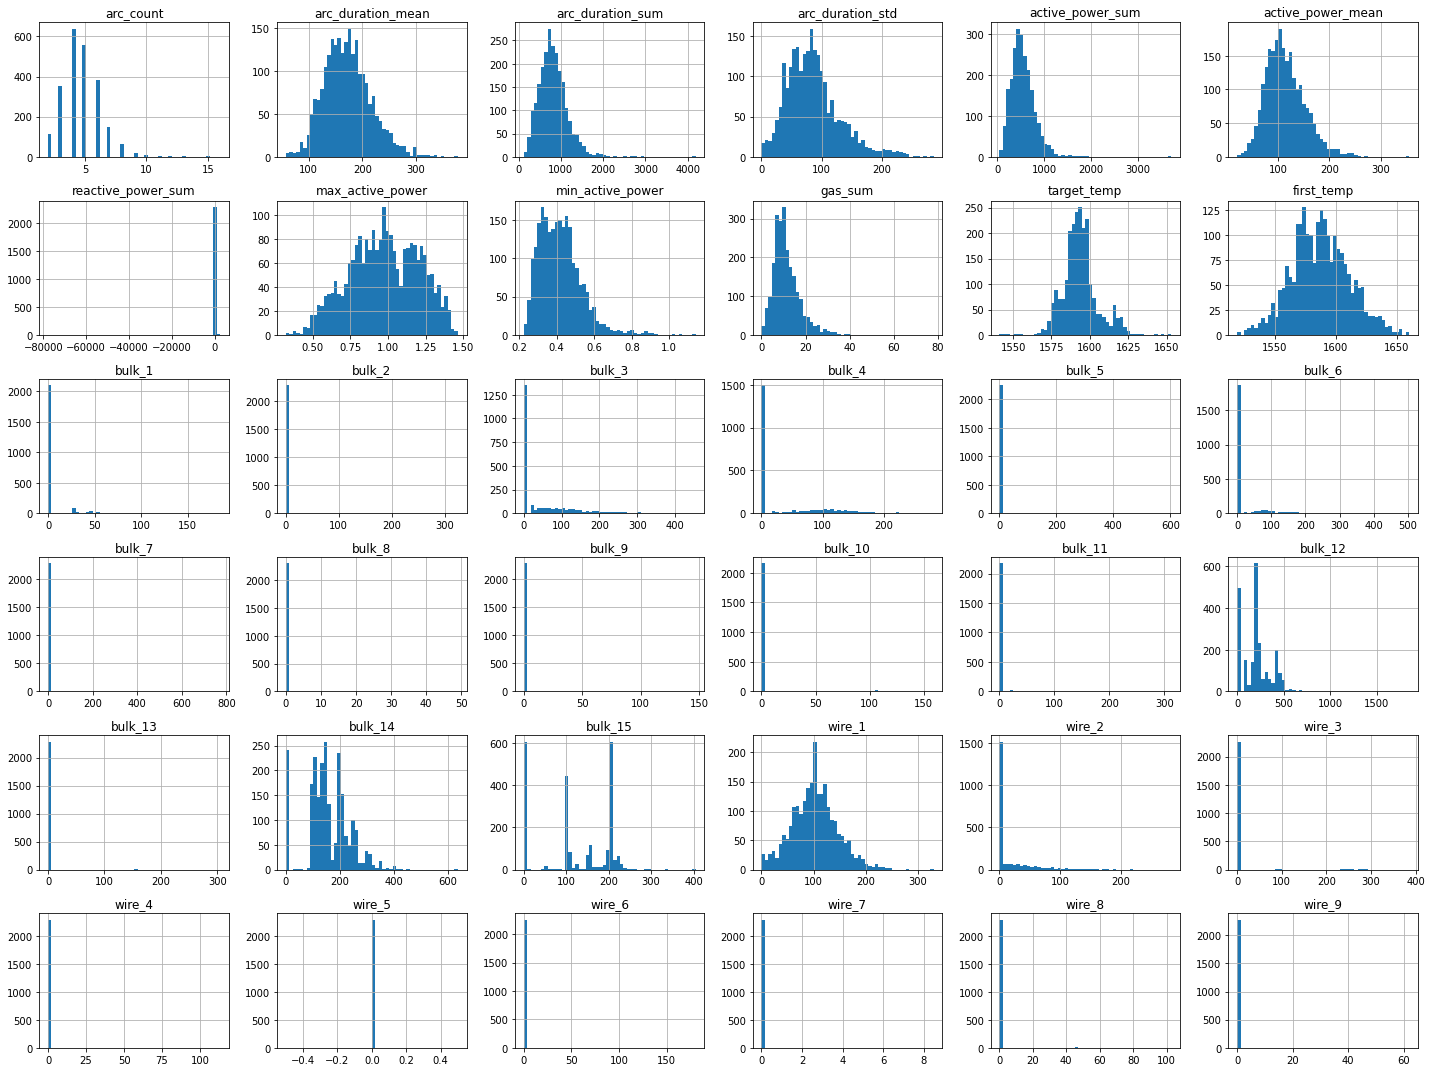

In [51]:
df[list(df.drop('key',axis=1).columns)].hist(figsize=(20, 15), bins=50)
plt.tight_layout()
plt.show()

Проведён повторный первичный осмотр распределений после объединения таблиц, чтобы убедиться в корректности признаков и отсутствии сильных искажений после агрегации. В результате визуализационного анализа были сделаны следующие выводы:

* Количество нагревов дугой имеет дискретное распределение, что указывает на категориальный характер признака. Для подробного изучения влияния признака на таргет необходимо использовать методы bar/countplot.


* Признаки arc_duration_sum, arc_duration_mean, arc_duration_std, active_power_sum, active_power_mean, max_active_power, min_active_power и gas_sum имеют плотное распределение без ярко выраженных выбросов, что позволяет использовать boxplot и гистограммы для оценки симметрии, разброса и возможных перекосов.


* Большинство признаков группы bulk имеют более 90% нулевых значений. Это указывает на их низкую вариативность данных. Можно рассмотреть признаки с самыми плотным распределением: bulk_1, bulk_3,bulk_4,bulk_12, bulk_14, bulk_15.


* Аналогично bulk признаки wire содержат мало разнообразных и информативных значений, большая часть данных заполнена нулями. Переменные wire_1 и wire_2 содержат наибольшую вариативность значений. Wire_5 является абсолютно бесполезным признаком: стандартное отклонение равно нулю, так как содержит только нулевые значения.

**Bulk признаки**

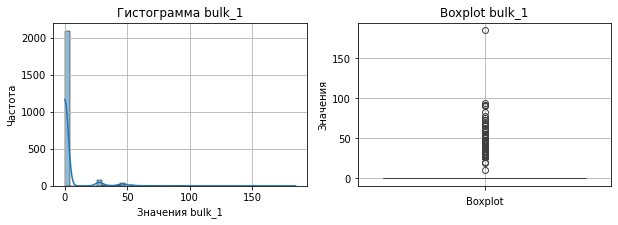

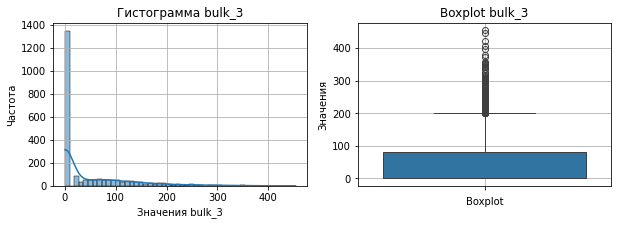

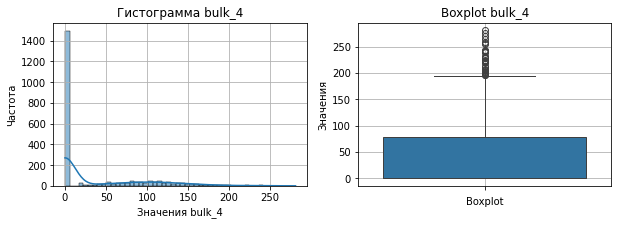

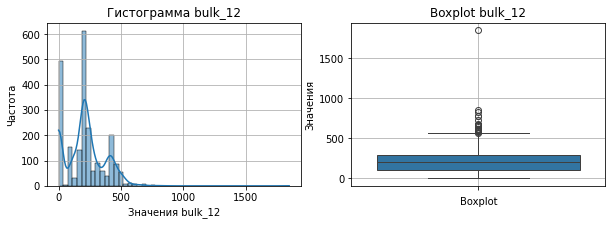

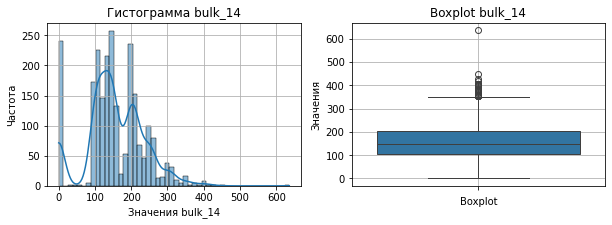

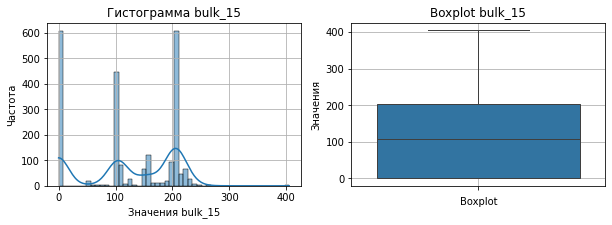

In [52]:
num_plot(df,[
    'bulk_1', 'bulk_3','bulk_4',
    'bulk_12', 'bulk_14', 'bulk_15'
],figsize=(10,3))

In [53]:
df[[
    'bulk_1', 'bulk_3','bulk_4',
    'bulk_12', 'bulk_14', 'bulk_15'
]].describe()

,bulk_1,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
count,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000
mean,3.470870,47.600870,37.432174,210.467826,155.120870,121.106522
std,12.484162,75.508903,58.813802,156.691026,80.489354,84.275819
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,105.000000,106.000000,0.000000
50%,0.000000,0.000000,0.000000,206.000000,149.000000,108.000000
75%,0.000000,80.250000,78.000000,290.000000,204.000000,204.000000
max,185.000000,454.000000,281.000000,1849.000000,636.000000,405.000000


По результатам визуализационного и статистического анализа были сделаны следующие выводы:


* **bulk_1:** Почти вся масса распределения сосредоточена у нуля (90+% наблюдений равны нулю), что указывает на редкое использование данного компонента. Среднее = 3.5, std = 12.5. На гистограмме длинный правый хвост и единичные выбросы >150-180, подтверждаемые boxplot-ом. Характеризует редкие технологические операции. 


* **bulk_3:** Данные распределены ненормально. 50% данных сосредоточены около 0 ([0,80]), ненулевые значения до 454, среднее 47.6, std=75.5. Длинный правый хвост, плотный группа наблюдений до 100, частые выбросы 200-400. Крайне неоднородный признак, отражает разные режимы подачи материала. Для модели необходимо ограничение верхнего перцентиля.


* **bulk_4:** Признак, указывающий на интенсивность отдельных этапов плавки: более 60% всех данных составляют нули, ненулевые значения неравномерны (80-130), среднее 37. Экстремальных выбросов не обнаружено.


* **bulk_12:** Многомодальный признак с ненормальным распределением.Медиана < среднего (206<210),что также подтверждает положительную ассиметрию в данных. Половина данных лежит в диапазоне от 105 до 290 (IQR = 185).


* **bulk_14:** Медиана 149, 50% данных лежит в диапазоне [106, 204], хвост до 636. Можно использовать без фильтрации, при необходимости стандартное масштабирование.


* **bulk_15:** Распределение имеет несколько пиков роста, выбросы отсутствуют. Среднее = 121, медиана = 108, IQR = [0,204] Умеренно вариативный, стабильный признак.

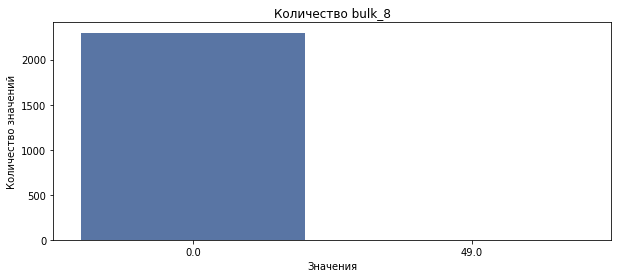

In [54]:
count_plot(df,'bulk_8')

bulk_8 содержит только два уникальных значения: 0 и 49, при этом значение 49 встречается однократно. Признак имеет практически нулевую дисперсию и не несёт полезной информации для модели

**Wire признаки**

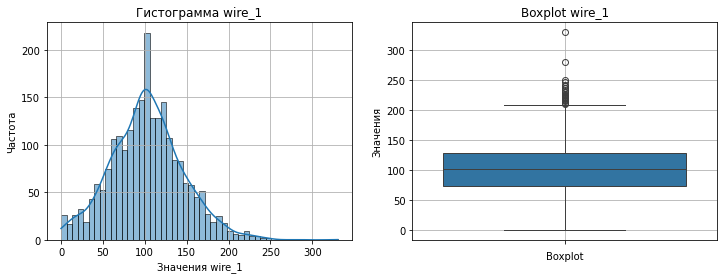

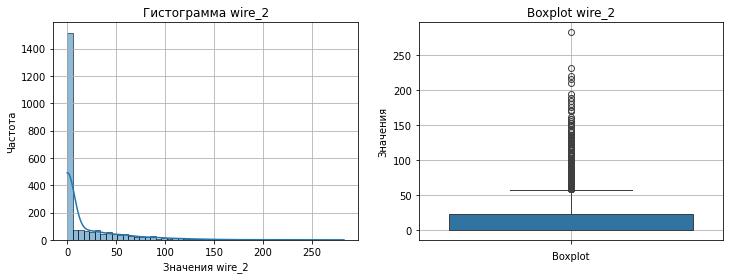

In [55]:
num_plot(df,[
    'wire_1', 'wire_2'
])

In [56]:
df[[
    'wire_1', 'wire_2'
]].describe()

,wire_1,wire_2
count,2300.000000,2300.000000
mean,102.511968,17.519531
std,43.450055,33.572231
min,0.000000,0.000000
25%,73.885499,0.000000
50%,101.119202,0.000000
75%,128.075222,23.051080
max,330.314424,282.780152


* **wire_1:**
Показатель имеет почти симметричное распределение с лёгким смещением вправо. Среднее (102.6) и медиана (101) практически совпадают, что говорит об отсутствии выраженной асимметрии. Основная масса наблюдений лежит в диапазоне 74–128 (IQR = 54). В данных присутствуют выбросы выше верхней границы Boxplot (>209), хвост короткий, редкие значения выше 250–300 единиц встречаются лишь пару раз.


* **wire_2:**
Распределение выраженно скошено вправо: более половины значений - нули, медиана = 0, при этом верхний квартиль = 23. Значительная часть массы сосредоточена у нуля, такое поведение указывает характерно для редких вспомогательных материалов. Редкие всплески активности (>200-282) формируют длинный правый хвост.

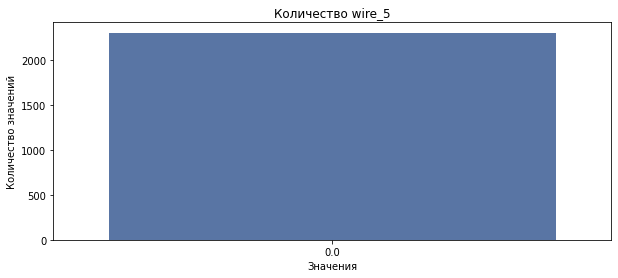

In [57]:
count_plot(df,'wire_5')

Wire_5 содержит лишь 1 уникальное значение, дисперсия равна 0. Признак неинформативен для модели.

**Основные признаки**

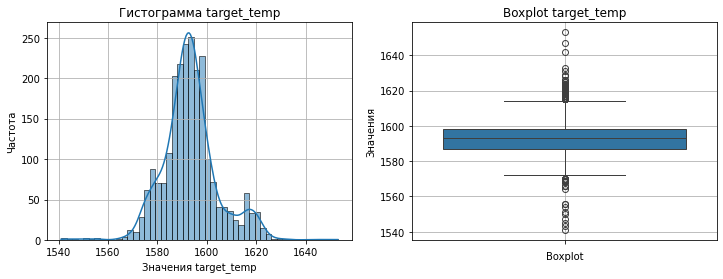

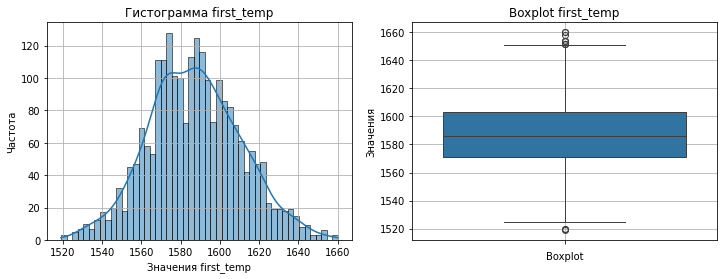

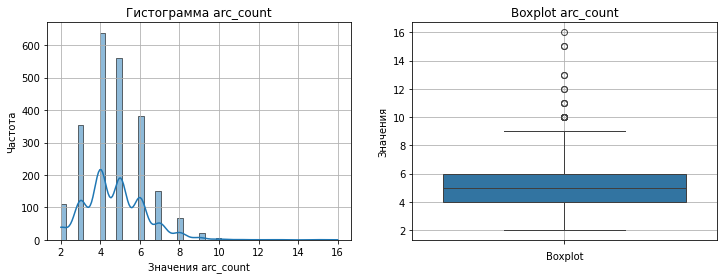

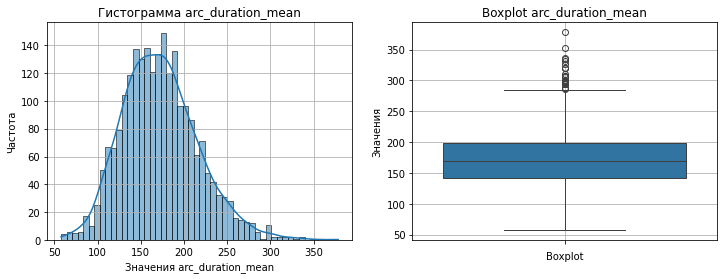

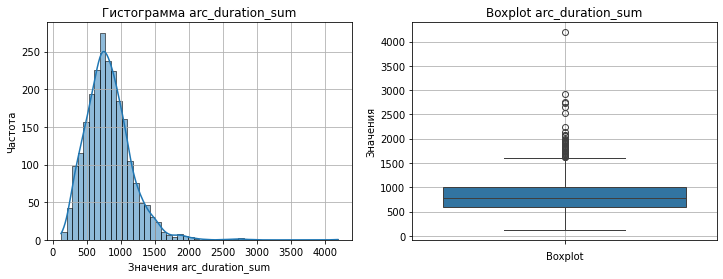

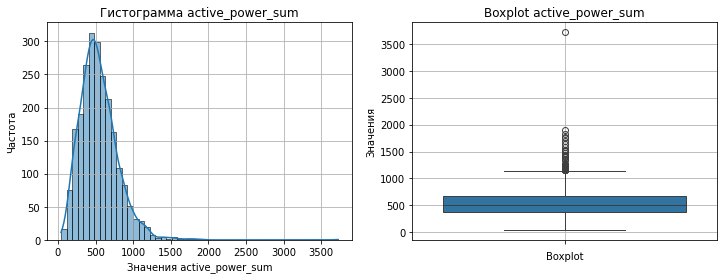

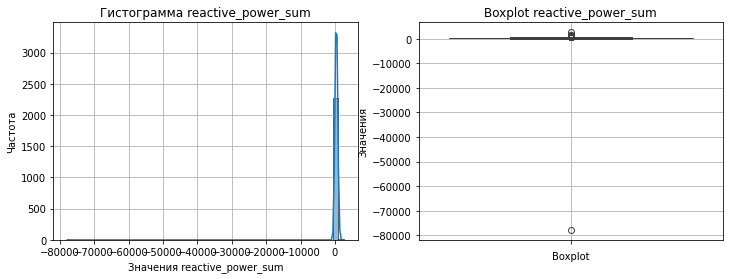

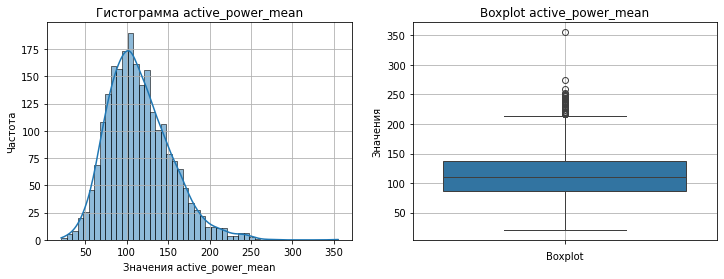

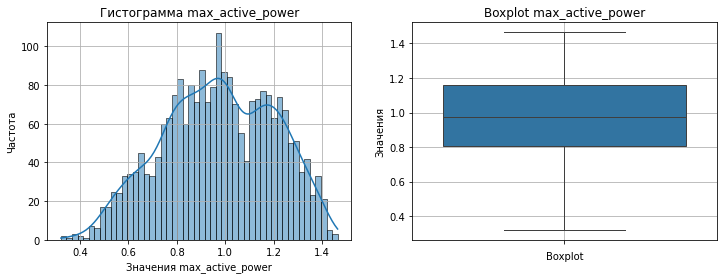

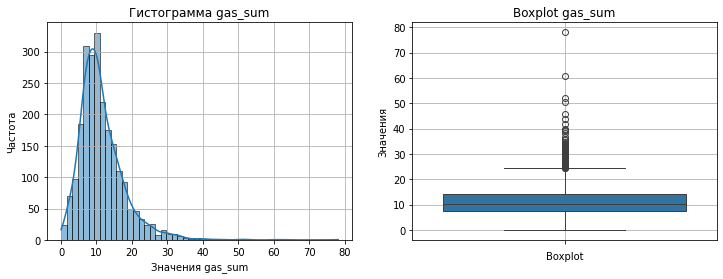

In [58]:
num_plot(df,[
    'target_temp','first_temp','arc_count', 'arc_duration_mean', 'arc_duration_sum',
    'active_power_sum', 'reactive_power_sum', 'active_power_mean',
    'max_active_power', 'gas_sum'
])

In [59]:
df[[
    'target_temp','first_temp','arc_count', 'arc_duration_mean', 'arc_duration_sum',
    'active_power_sum', 'reactive_power_sum', 'active_power_mean',
    'max_active_power', 'gas_sum'
]].describe()

,target_temp,first_temp,arc_count,arc_duration_mean,arc_duration_sum,active_power_sum,reactive_power_sum,active_power_mean,max_active_power,gas_sum
count,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000
mean,1593.422174,1587.086957,4.736522,172.425987,815.283043,544.154184,366.241390,114.884972,0.971367,11.428465
std,11.205989,23.481945,1.567439,43.580947,335.432839,254.325072,1641.734687,38.031333,0.229245,6.397980
min,1541.000000,1519.000000,2.000000,57.666667,119.000000,41.494029,-77819.735633,20.747015,0.321005,0.008399
25%,1587.000000,1571.000000,4.000000,141.475000,588.000000,374.210701,274.666449,87.543850,0.805167,7.339834
50%,1593.000000,1586.000000,5.000000,169.700000,782.000000,511.657292,375.168051,109.884645,0.974138,10.141563
75%,1598.000000,1603.000000,6.000000,199.000000,996.250000,682.289481,496.898740,138.247524,1.159022,14.227257
max,1653.000000,1660.000000,16.000000,378.000000,4189.000000,3718.054401,2612.081299,354.998656,1.463773,77.995040


* **target_temp:**
Температура плавки достаточно стабильная: большая часть наблюдений находится между 1587 и 1598, медиана почти совпадает со средним 1593, разброс небольшой, std 11.2. Явных выбросов нет, распределение близко к нормальному.


* **first_temp:**
Температура на начальном этапе в среднем 1587, медиана 1586, разброс умеренный (std 23.5). Большинство значений сосредоточено в диапазоне 1571–1603, распределение близко к симметричному, выбросов нет. Признак стабилен и вариативен.


* **arc_count:**
Количество циклов дуги обычно 4–6, среднее 4.7, медиана 5. Редкие высокие значения до 16 единичны и могут отражать нестандартные плавки или технологические сбои. Процесс в целом предсказуемый, экстремумы встречаются крайне редко.


* **arc_duration_mean:**
Среднее время одного цикла около 172 секунд, иногда наблюдаются длительные циклы свыше 300 секунд. Распределение слегка скошено вправо, виднеются значения, которые не входя в верхнюю границу уса boxplot. 


* **arc_duration_sum:**
Суммарная длительность дуг сильно варьируется: среднее 815 секунд, std = 335, встречаются редкие и крайне длинные (>4000) выбросы. Данные сильно скошены вправо.


* **active_power_sum:**
Энергия активной мощности демонстрирует несколько режимов работы: мультимодальное распределение с длинным правым хвостом, среднее 544, std 254, максимальные значения до 3718 - это редкие пики.


* **reactive_power_sum:**
Наблюдаются аномальные значения: отрицательные и экстремально высокие, среднее 365, стандартное отклоенине 1660, диапазон до 2612 и ниже –77 819. Данные явно нарушают физический смысл. Признак требует очистки от аномальных значений.


* **active_power_mean:**
Средняя мощность одного цикла около 115, std 38, распределение умеренно скошено вправо. Встречаются единичные значения выше 300. В остальном признак стабильный и пригоден для использования в модели.


* **max_active_power:**
Максимальные значения активной мощности узкие и симметричные, концентрируются в диапазоне [0.8,1.2], среднее 0.97. Признак надёжный и однородный, может хорошо коррелировать с target_temp.


* **gas_sum:**
Расход газа сильно неравномерный, есть единичные экстремумы, которые в восемь раз превышают медиану 10.1 (max=77.99), минимальное значение приближено к нулю, std = 6.4, среднее значение 11.4.

In [60]:
print('Количество строк до фильтрации:',df.shape[0])
df = df.loc[df['reactive_power_sum'] >= 0]
print('Количество строк после фильтрации:',df.shape[0])

Количество строк до фильтрации: 2300
Количество строк после фильтрации: 2299


Удалению при фильтрации подверглась только 1 строчка

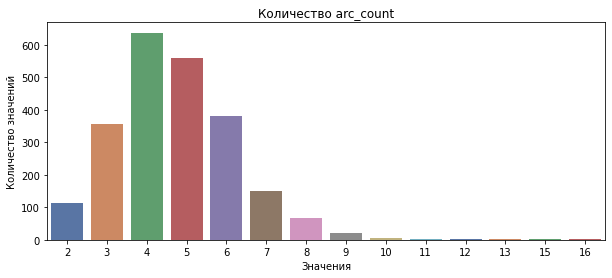

In [61]:
count_plot(df,'arc_count')

Наиболее частые значения количества нагревов дугой являются:

* 4 нагрева (Содержит наибольшее количество значений в датасете: 637) - Мода
* 5 нагревов (559 раз)
* 6 нагревов (382 раз)
* 3 нагрева (355 раз)

Самые редкие значения количества нагревов:
* 16 нагревов (единожды)
* 12,13,15 нагревов (дважды)
* 11 нагревов (трижды)
* 10 нагревов (7 раз)

In [72]:
df['arc_count'].value_counts()

4     637
5     559
6     382
3     355
7     150
2     112
8      66
9      21
10      7
11      3
12      2
13      2
15      2
16      1
Name: arc_count, dtype: int64

**Корреляционный анализ**

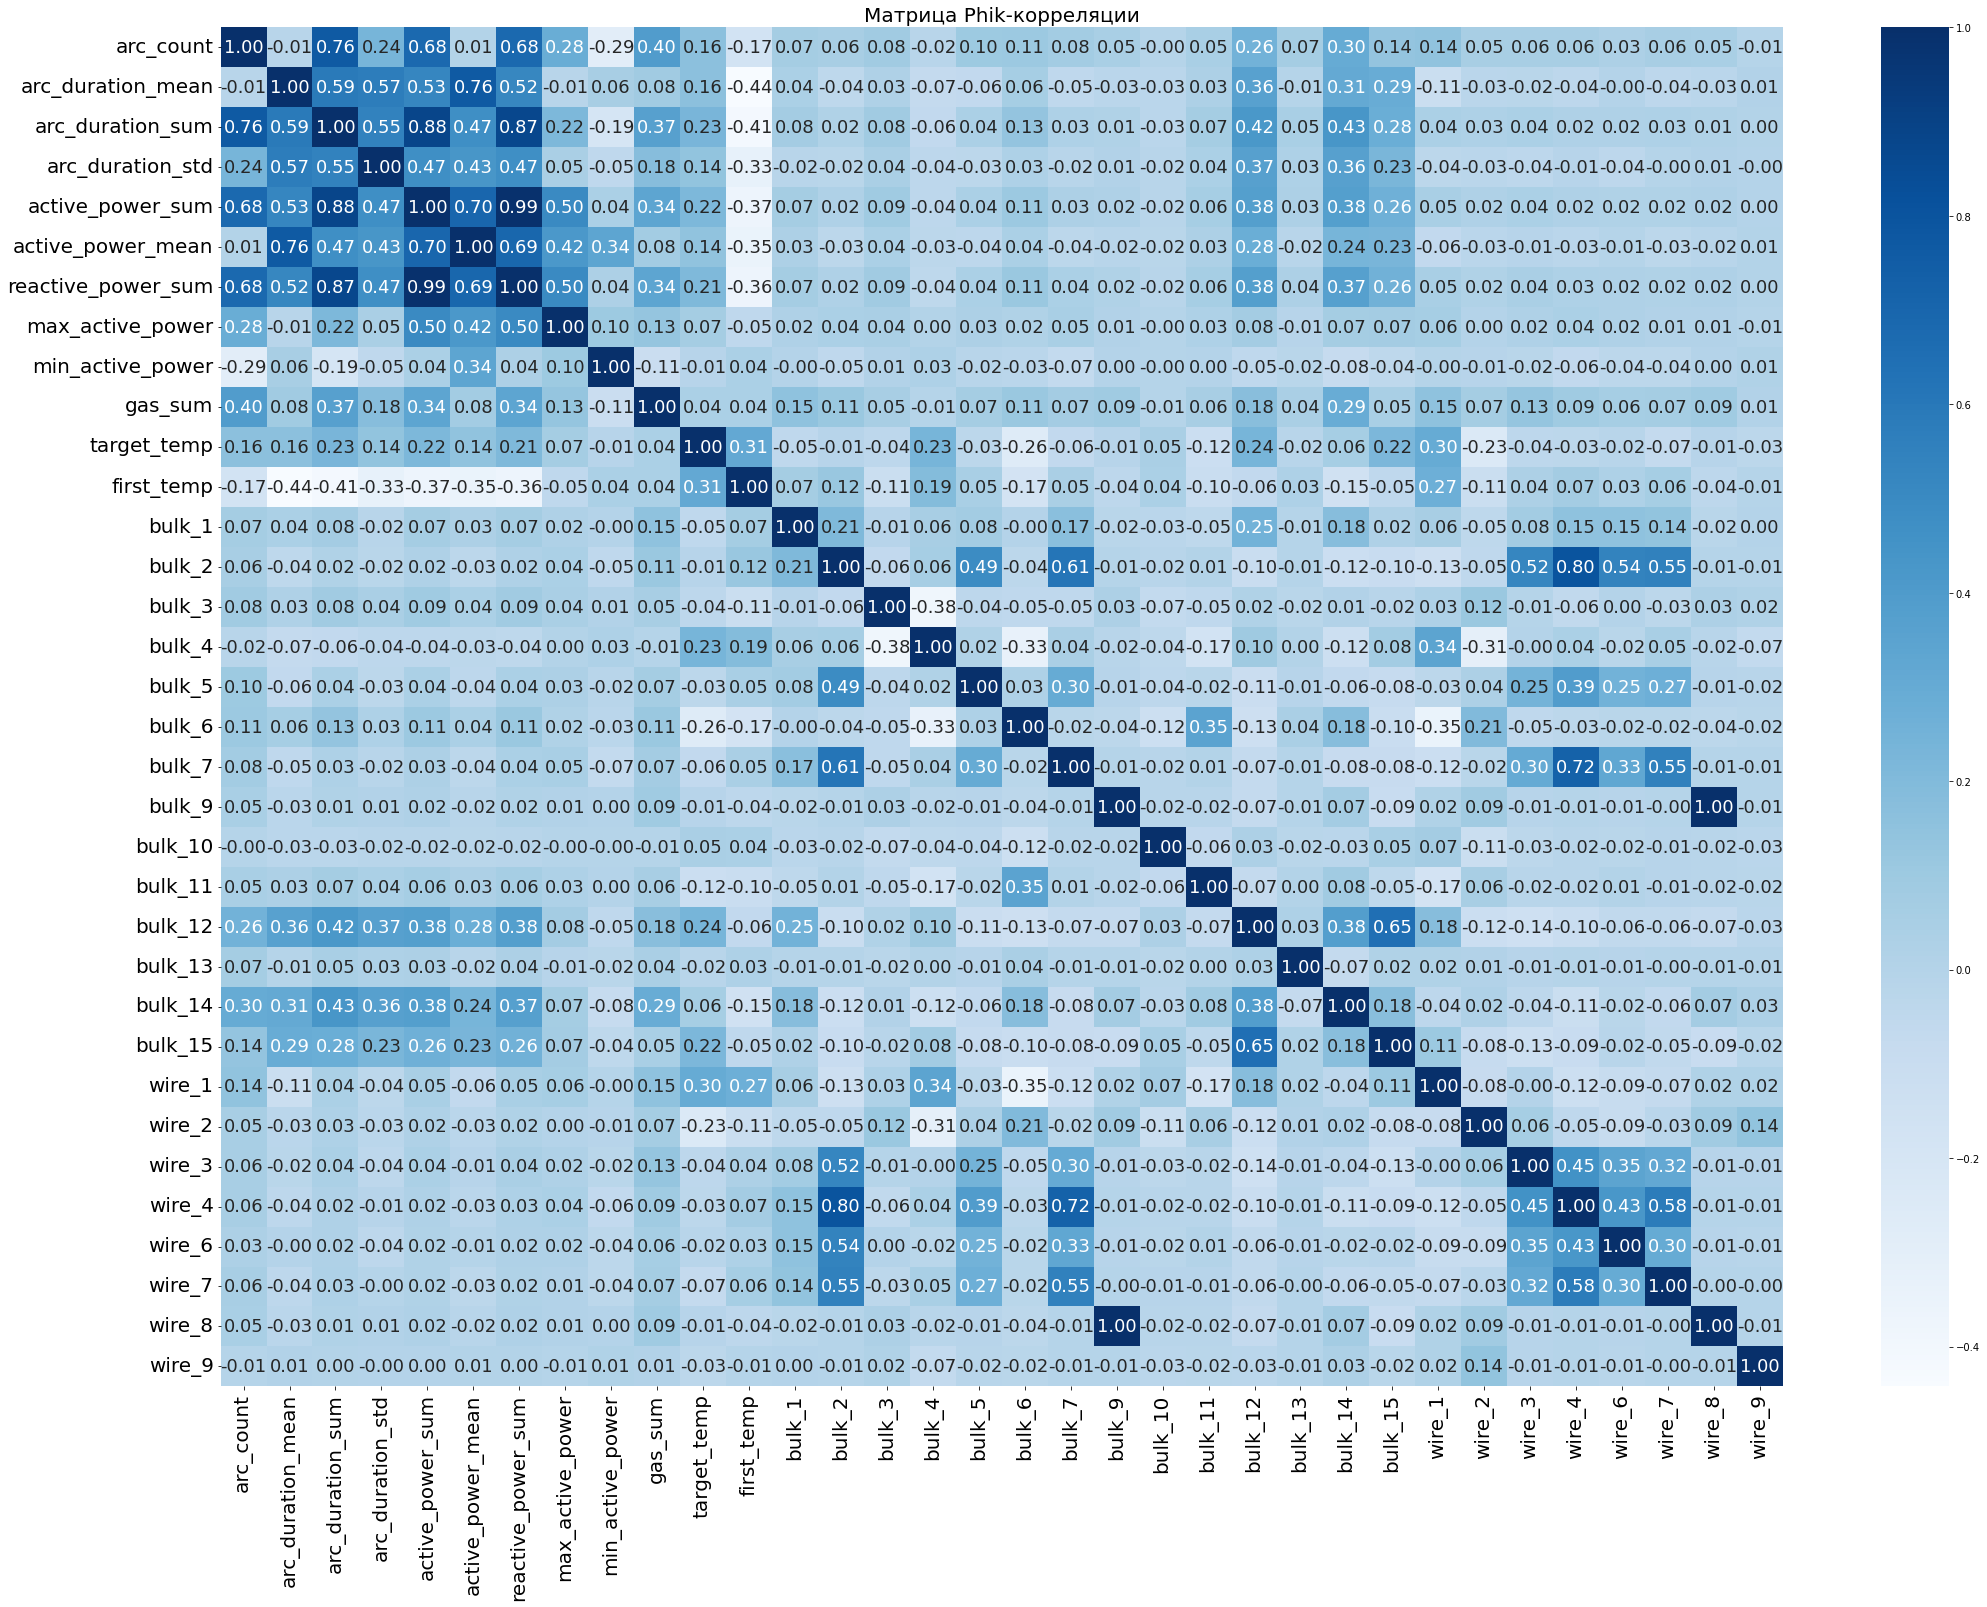

In [62]:
phik_corr = df.drop(['key','wire_5','bulk_8'],axis=1).corr(method='spearman')

plt.figure(figsize=(35, 25))
sns.heatmap(phik_corr, 
            annot=True, 
            fmt=".2f", 
            cmap='Blues',
            annot_kws={"size":18},
            cbar=True)
plt.title('Матрица Phik-корреляции',fontsize=20)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20, rotation=0)
plt.show()

**Корреляция признаков с таргетом**

Корреляционная матрица показывает, что связь между признаками и целевой переменной в целом слабая (|r| < 0.5).Наибольшую линейную зависимость с целевой переменной демонстрируют:
* *first_temp* (r=0.31),
* *wire_1* (r=0.30), 
* *wire_2* (r=-0.23), 
* *bulk_6* (r=-0.28), 
* *bulk_12* (r=0.24), 
* *bulk_15* (r=0.22), 
* *bulk_4* (r=0.23),
* *bulk_6* (r=-0.26),
* *arc_duration_sum* (r=0.23),
* *active_power_sum* (r=0.22)

**Мультиколлинеарность**

Высокая взаимная корреляция между признаками приводит к мультиколлинеарности, при которой модель не может надёжно оценить вклад каждого признака и распределяет вес между ними.

Полная корреляция выявлена между: *bulk_9* и *wire_8* (r=1.00), а также почти полная между *active_power_sum* и *reactive_power_sum* (r=0.99); один из признаков каждой пары необходимо исключить. Было принято решение исключить: *wire_8* и *reactive_power_sum*. 

Для остальных признаков (|r| ≤ 0.9) выраженной мультиколлинеарности не обнаружено.

# Обучение модели

**Разбивка данных**

In [63]:
X = df.drop(['key','target_temp'],axis=1)
y = df['target_temp']

Отделяю входные признаки от целевой переменной

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

Делю данные на тренировочную и тестовую выборки

**Pipeline**

In [65]:
num_col = ['arc_count', 'arc_duration_mean', 'arc_duration_sum', 'arc_duration_std',
        'active_power_sum', 'active_power_mean', 'first_temp',
        'max_active_power',  'min_active_power', 'gas_sum',
        'bulk_1', 'bulk_2', 'bulk_3','bulk_4', 'bulk_5', 
        'bulk_6', 'bulk_7', 'bulk_9', 'bulk_10',
        'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15',
        'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6',
        'wire_7', 'wire_9']

#Пайплайны для признаков
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer([
    ('num', num_pipe, num_col)
], remainder='drop')

pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

Создаю пайплайн с baseline моделью и предобработкой

In [66]:
param_grid = [
    # LinearRegression()
    {
        'models': [LinearRegression()]
    },
    # DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        "models__max_depth": [5, 10, 15],
        "models__min_samples_split": [2, 5, 10],
        "models__min_samples_leaf": [1, 5, 10],
    },
    
    # RandomForestRegressor()
    {   "models": [RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)],
        "models__n_estimators": [100, 300, 500],
        "models__max_depth": [5, 10, 15],
        "models__min_samples_split": [2, 5, 10],
        "models__min_samples_leaf": [1, 2, 4]
    },

    #CatBoost()
    {
        "models": [cat_model],
        'models__learning_rate': [0.01, 0.012, 0.015],
        'models__depth': [5, 6, 7],
        'models__l2_leaf_reg': [8, 10, 12, 14],
        'models__bagging_temperature': [3, 4, 5, 6],
        'models__random_strength': [0.5, 0.8, 1.0, 1.5],
        'models__border_count': [128, 255]
    }
]

Создаю список моделей и диапазон значений гипперпараметров этих моделей для подбора наилучшей модели путем случайного поиска на кросс-валидации.

In [67]:
randomized_search = RandomizedSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=30)

randomized_search.fit(X_train, y_train)



best_est = randomized_search.best_estimator_
best_params = best_est.named_steps['models']
best_params = best_params.get_params()
print('Гипперпараметры лучшей модели:', best_params)
print ('Метрика лучшей модели на кросс-валидации:', (randomized_search.best_score_ * -1))

Гипперпараметры лучшей модели: {'loss_function': 'MAE', 'random_seed': 61025, 'verbose': False, 'eval_metric': 'MAE', 'grow_policy': 'SymmetricTree', 'random_strength': 1.0, 'learning_rate': 0.012, 'l2_leaf_reg': 8, 'depth': 5, 'border_count': 255, 'bagging_temperature': 6}
Метрика лучшей модели на кросс-валидации: 6.057847767793962


В рамках пайплайна для прогнозирования температуры сплава были протестированы модели:

* LogisticRegression,
* DecisionTreeRegressor,
* RandomForestRegressor,
* CatBoostRegressor

Данные обрабатывались были отмасштабированы с помощью StandardScaler. Качество модели оценивалось с помощью метрики mae для удобства интерпретации значения метрики.

По результатам кросс-валидации наилучший результат показала модель CatBoostClassifier со следующими параметрами:


{'loss_function': 'MAE', 'random_seed': 61025, 'verbose': False, 'eval_metric': 'MAE', 'grow_policy': 'SymmetricTree', 'random_strength': 1.0, 'learning_rate': 0.012, 'l2_leaf_reg': 8, 'depth': 5, 'border_count': 255, 'bagging_temperature': 6}


Метрика MAE показала среднее значение 6.06 на кросс-валидации.

**Тестирование модели**

In [68]:
best_model = randomized_search.best_estimator_
pred = best_model.predict(X_test)
print("Значение метрики mae на тестовых данных:",mean_absolute_error(pred,y_test))

Значение метрики mae на тестовых данных: 6.142655264592985


Метрика на тесте: 6.14. Модель успешно нашла зависимости и умеет обобщаться на новых данных

In [69]:
dummy_model = DummyRegressor()
dummy_model.fit(X_train,y_train)
dummy_pred = dummy_model.predict(X_test)
print("Значение метрики mae на тестовых данных для примитивной модели:", mean_absolute_error(dummy_pred,y_test))

Значение метрики mae на тестовых данных для примитивной модели: 8.207797841218603


Примитивная модель на основе средних значений показала результ на тестовых данных хуже (8.21 > 6.14). Это также указывает на то, что лучшая модель обучилась корректно.

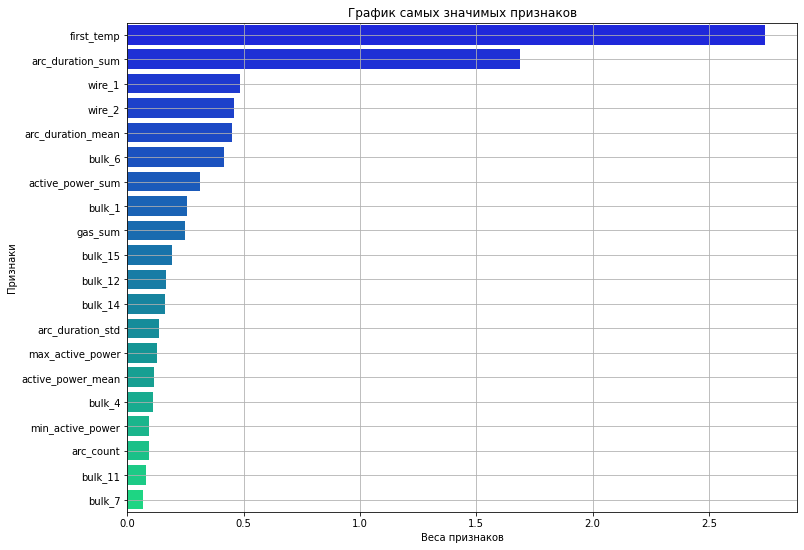

In [70]:
perm = PermutationImportance(best_model, scoring='neg_mean_absolute_error', n_iter=5, random_state=42)
perm.fit(X_train, y_train)
exp = eli5.explain_weights(perm, feature_names=X_train.columns.tolist())
df_feature_imp = eli5.format_as_dataframe(exp)
df_feature_imp_sorted = df_feature_imp.sort_values('weight', ascending=False)

plt.figure(figsize=(12,9))
sns.barplot(data = df_feature_imp_sorted, x='weight', y='feature',palette='winter', orient='h')
plt.title('График самых значимых признаков')
plt.xlabel('Веса признаков')
plt.ylabel('Признаки')
plt.grid()
plt.show()

Топ 10 самых важных признаков для модели:

**1)**  first_temp:	2.742506	

**2)**	arc_duration_sum: 1.688675

**3)**	wire_1: 0.483446	

**4)**	wire_2:	0.458473	

**5)**	arc_duration_mean: 0.448107	

**6)**	bulk_6: 0.416504	

**7)**	active_power_sum: 0.312268	

**8)**	bulk_1: 0.254878

**9)**	gas_sum: 0.248011

**10)**	bulk_15: 0.0.191676

# Общий вывод
Была поставлена задача — спрогнозировать температуру сплава на этапе обработки стали для оптимизации энергопотребления на металлургическом комбинате «Стальная птица».
Для решения задачи были выполнены следующие этапы:

**1. Загрузка и первичный анализ данных**


Данные успешно загружены и объединены по ключу партии.
Целевой признак — температура сплава. Проведён первичный анализ распределения: выявлены левосторонние выбросы и симметрия mean≈median, что свидетельствует о статистической компенсации хвостов.
Типы данных преобразованы, пропуски и некорректные значения обработаны.


**2. Feature engineering и очистка данных**


Созданы агрегированные признаки (duration, active_power_sum, reactive_power_sum, gas_sum и др.), отражающие длительность и энергоёмкость плавки.
Обнаружены и удалены аномальные значения (reactive_power_sum, gas_sum, arc_duration_sum).
Данные агрегированы по ключу партии, что позволило использовать каждую плавку как единичный объект наблюдения.


**3. Исследовательский анализ данных**


Проведён анализ распределений и выбросов для групп признаков. Было выявлено, что:

* Большинство bulk и wire признаков имеют более 90 % нулей — низкая вариативность;

* У wire_1, wire_2, bulk_6, bulk_12, bulk_15 обнаружена наибольшая связь с температурой;

* reactive_power_sum с active_power_sum и bulk_9 и wire_8 сильно коррелируют (r≈0.99); один из пар признаков был исключён.


**4. Построение и оценка моделей**


Проведено тестирование моделей:

* LinearRegression,

* DecisionTreeRegressor,

* RandomForestRegressor,

* CatBoostRegressor.

По результатам кросс-валидации наилучшие результаты показала модель CatBoostRegressor со следующими параметрами:

{'loss_function': 'MAE', 'random_seed': 61025, 'verbose': False, 'eval_metric': 'MAE', 'grow_policy': 'SymmetricTree', 'random_strength': 1.0, 'learning_rate': 0.012, 'l2_leaf_reg': 8, 'depth': 5, 'border_count': 255, 'bagging_temperature': 6}

**5. Результаты:**

* Средняя ошибка на кросс-валидации: MAE = 6.06.

* Ошибка на тесте: MAE = 6.14 (ниже, чем на валидации).

* Бейзлайн на средних значениях показал MAE = 8.21, что подтверждает корректность модели.

**6. Важные признаки**
Наибольшее влияние на температуру оказали:


first_temp, arc_duration_sum, wire_1, wire_2, arc_duration_mean, bulk_6, active_power_sum, bulk_1, gas_sum, bulk_15

**7. Рекомендации**
Можно посоветовать глубже изучить влияние редких материалов bulk и wire. Дополнительно рассмотреть степень VIF, чтобы отсеить вроятность мультиколлинеарности между признаками.